Reached r = 384442.6 km at t = 32099700.0 s
t_days = 371.52 days
Final mass mf = 890.89 kg
Propellant used = 109.11 kg


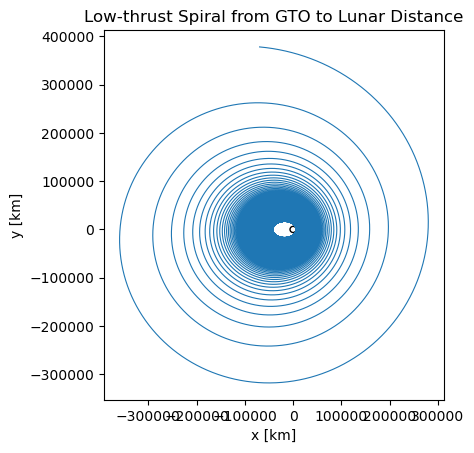

In [5]:
import math
import matplotlib.pyplot as plt

# --- Constants ---
mu = 398600.4418   # km^3/s^2
Re = 6378.0        # km

# GTO geometry
rp = Re + 200.0    # km
ra = Re + 36000.0  # km
a0 = 0.5 * (rp + ra)

# Perigee speed on the elliptic GTO
vp0 = math.sqrt(mu * (2.0/rp - 1.0/a0))

# Thruster / spacecraft
T_N = 0.1          # N
Isp = 3000.0       # s
g0  = 9.80665      # m/s^2
m0  = 1000.0       # kg

rf = 384400.0      # km target radius

# Mass flow rate (engine always on)
mdot = -T_N / (Isp * g0)   # kg/s

def deriv(state):
    """Return time derivative (dx, dy, dvx, dvy, dm)."""
    x, y, vx, vy, m = state
    r = math.hypot(x, y)

    # Gravity
    ax_g = -mu * x / r**3
    ay_g = -mu * y / r**3

    # Tangential thrust (aligned with velocity)
    v = math.hypot(vx, vy)
    if m <= 0 or v == 0.0:
        ax_t = ay_t = 0.0
        dm = 0.0
    else:
        # Thrust acceleration magnitude in km/s^2
        aT = (T_N / m) / 1000.0
        ax_t = aT * (vx / v)
        ay_t = aT * (vy / v)
        dm = mdot

    return (vx, vy, ax_g + ax_t, ay_g + ay_t, dm)

def rk4_step(state, dt):
    k1 = deriv(state)
    s2 = tuple(state[i] + 0.5*dt*k1[i] for i in range(5))
    k2 = deriv(s2)
    s3 = tuple(state[i] + 0.5*dt*k2[i] for i in range(5))
    k3 = deriv(s3)
    s4 = tuple(state[i] + dt*k3[i] for i in range(5))
    k4 = deriv(s4)
    return tuple(
        state[i] + dt*(k1[i] + 2*k2[i] + 2*k3[i] + k4[i])/6.0
        for i in range(5)
    )

# Initial state at perigee of elliptic GTO
state = (rp, 0.0, 0.0, vp0, m0)
t = 0.0

dt = 300.0          # time step [s]
max_steps = 200_000

xs, ys = [], []

for step in range(max_steps):
    x, y, vx, vy, m = state
    r = math.hypot(x, y)
    xs.append(x)
    ys.append(y)
    if r >= rf:
        break
    state = rk4_step(state, dt)
    t += dt

x, y, vx, vy, mf = state
r_final = math.hypot(x, y)

print(f"Reached r = {r_final:.1f} km at t = {t:.1f} s")
print(f"t_days = {t/86400:.2f} days")
print(f"Final mass mf = {mf:.2f} kg")
print(f"Propellant used = {m0 - mf:.2f} kg")

# Plot orbit
fig, ax = plt.subplots()
ax.plot(xs, ys, linewidth=0.8)
earth = plt.Circle((0, 0), Re, fill=False)
ax.add_artist(earth)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('Low-thrust Spiral from GTO to Lunar Distance')
plt.show()


In [13]:
import math
import matplotlib.pyplot as plt

# ============================================================
# CONSTANTS
# ============================================================
mu = 398600.4418   # km^3/s^2
Re = 6378.0        # km

# Initial GTO parameters
rp = Re + 200.0
ra = Re + 36000.0
a0 = 0.5*(rp + ra)
vp0 = math.sqrt(mu*(2/rp - 1/a0))

# Spacecraft
T_N = 0.1          # N
Isp = 3000.0       # s
g0  = 9.80665
m0  = 1000.0

# Target (Moon distance)
rf = 384400.0

mdot = -T_N/(Isp*g0)   # constant mass flow


# ============================================================
# TRUE ANOMALY FUNCTION
# ============================================================
def true_anomaly(x, y, vx, vy):
    r = math.hypot(x, y)
    h = x*vy - y*vx

    ex = (vy*h/mu) - x/r
    ey = (-vx*h/mu) - y/r
    e = math.hypot(ex, ey)

    cos_nu = (ex*x + ey*y)/(e*r)
    cos_nu = max(-1.0, min(1.0, cos_nu))

    nu = math.acos(cos_nu)

    vr = (x*vx + y*vy)/r
    if vr < 0:
        nu = -nu

    return nu   # radians


# ============================================================
# VARIABLE TIMESTEP
# dt shrinks when velocity is large (perigee)
# ============================================================
def compute_dt(v):
    C = 5e4      # tuning constant
    v_mps = v*1000
    dt = C/v_mps
    return max(15.0, min(dt, 600.0))   # clamp to safe range


# ============================================================
# DERIVATIVE
# ============================================================
def deriv(state, thrust_on):
    x, y, vx, vy, m = state
    r = math.hypot(x, y)

    # Gravity
    ax_g = -mu*x/r**3
    ay_g = -mu*y/r**3

    if not thrust_on or m <= 0:
        return (vx, vy, ax_g, ay_g, 0.0)

    v = math.hypot(vx, vy)
    aT = (T_N/m)/1000.0   # km/s^2

    ax_t = aT*(vx/v)
    ay_t = aT*(vy/v)

    return (vx, vy, ax_g+ax_t, ay_g+ay_t, mdot)


# ============================================================
# RK4 STEP
# ============================================================
def rk4(state, dt, thrust_on):
    k1 = deriv(state, thrust_on)
    s2 = tuple(state[i] + 0.5*dt*k1[i] for i in range(5))
    k2 = deriv(s2, thrust_on)
    s3 = tuple(state[i] + 0.5*dt*k2[i] for i in range(5))
    k3 = deriv(s3, thrust_on)
    s4 = tuple(state[i] + dt*k3[i] for i in range(5))
    k4 = deriv(s4, thrust_on)

    return tuple(
        state[i] + dt*(k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6.0
        for i in range(5)
    )


# ============================================================
# SIMULATOR (MAIN FUNCTION)
# nu_c_deg = half-width of arc (45 = 90° arc, 90 = 180° arc, 180 = full circle)
# ============================================================
def simulate(nu_c_deg):
    nu_c = math.radians(nu_c_deg)

    state = (rp, 0.0, 0.0, vp0, m0)
    t = 0.0
    thrust_time = 0.0

    xs, ys = [], []

    for step in range(3_000_000):
        x, y, vx, vy, m = state
        r = math.hypot(x, y)

        xs.append(x)
        ys.append(y)

        if r >= rf:
            break

        nu = true_anomaly(x, y, vx, vy)

        thrust_on = abs(nu) <= nu_c

        v = math.hypot(vx, vy)
        dt = compute_dt(v)

        if thrust_on:
            thrust_time += dt

        state = rk4(state, dt, thrust_on)
        t += dt

    return t, thrust_time, state, xs, ys


# ============================================================
# PLOTTING + RESULT PRINTER
# ============================================================
def plot_orbit(xs, ys, title):
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys, linewidth=0.8, label="Trajectory")
    plt.gca().add_artist(plt.Circle((0,0), Re, fill=False, color='blue'))
    plt.gca().set_aspect('equal','box')
    plt.xlabel("x [km]")
    plt.ylabel("y [km]")
    plt.title(title)
    plt.grid(True)
    plt.show()


def print_results(t, thrust_time, state):
    xf, yf, vxf, vyf, mf = state
    rf_final = math.hypot(xf, yf)
    dv_eff = Isp*g0*math.log(m0/mf)

    print("----------------------------------------------------")
    print(f"Final radius:      {rf_final:12.3f} km")
    print(f"Calendar time:     {t/86400:12.3f} days")
    print(f"Engine ON time:    {thrust_time/86400:12.3f} days")
    print(f"Duty cycle:        {thrust_time/t:12.4f}")
    print(f"Final mass:        {mf:12.3f} kg")
    print(f"Propellant used:   {m0 - mf:12.3f} kg")
    print(f"Effective Δv:      {dv_eff/1000:12.3f} km/s")
    print("----------------------------------------------------")


In [ ]:
t, ton, state, xs, ys = simulate(45)
print_results(t, ton, state)
plot_orbit(xs, ys, "90° Perigee Arc Thrust (±45°)")

In [ ]:
t, ton, state, xs, ys = simulate(90)
print_results(t, ton, state)
plot_orbit(xs, ys, "180° Perigee Arc Thrust (±90°)")


(44376103.60574357,
 2775320.0,
 (-37289.835133279965,
  20049.610941854786,
  -2.7181593630949794,
  -0.403002853079053,
  990.5665373332993),
 [6578.0,
  6576.157891021862,
  6570.634855622578,
  6561.44074465649,
  6548.591895344323,
  6532.111010683967,
  6512.026993458338,
  6488.374737574295,
  6461.19488010817,
  6430.533517979283,
  6396.441893610531,
  6358.976054257251,
  6318.196489888943,
  6274.16775459454,
  6226.958076456233,
  6176.638960708297,
  6123.2847907778005,
  6066.972431507148,
  6007.780838499272,
  5945.790677120326,
  5881.083954257351,
  5813.7436654740295,
  5743.853459749596,
  5671.497323535959,
  5596.759285435918,
  5519.723142399084,
  5440.4722079577705,
  5359.089082686982,
  5275.655446773322,
  5190.251874318231,
  5102.9576687813405,
  5013.850718788693,
  4923.007373386072,
  4830.502335707177,
  4736.408573946767,
  4640.7972484769425,
  4543.737653917062,
  4445.2971749610515,
  4345.541254776776,
  4244.533374817706,
  4142.335044924415,
  4